# ONNX

In [1]:
import numpy as np
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [3]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
len(test_df)

28000

# **Visualizing the digits** 

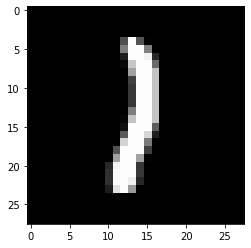

In [6]:
import matplotlib.pyplot as plt

random_digit = train_df.sample().iloc[:,1:].values.reshape(28,28,1)
plt.imshow(random_digit, cmap='gray')

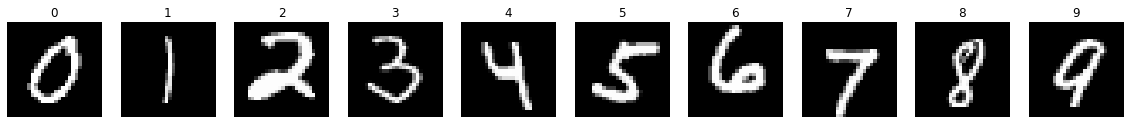

In [7]:
all_randoms = train_df.sample(frac=1).drop_duplicates('label').sort_values(by='label')
figure = plt.figure(figsize=(20,3))
for i in range(1, 11):
    img = all_randoms.iloc[i-1,1:].values.reshape(28,28)
    label = all_randoms.iloc[i-1,0]
    figure.add_subplot(1,10,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img, cmap='gray')

<AxesSubplot:>

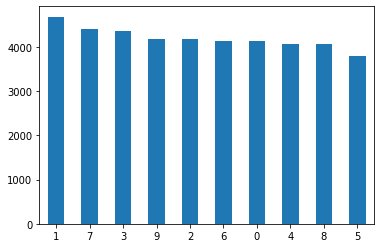

In [8]:
train_df['label'].value_counts().plot.bar(rot=0)

# **Pytorch**

In [9]:
import torch
import torch.nn as nn

# **Custom Dataset**

In [10]:
class DigitDataset:
    
    def __init__(self, data, labels = None, is_test = False):
        self.data = data / 255.0
        self.labels = labels if labels is not None else None
        self.is_test = is_test
    
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        
        sample = self.data[idx,:]
        
        if self.is_test is False:
            
            label = self.labels[idx]
            
            return (
                torch.tensor(sample, dtype=torch.float).view(28,28).unsqueeze(0),
                torch.tensor(label, dtype=torch.long)
            )
        
        else:
            return torch.tensor(sample, dtype=torch.float)

In [11]:
from sklearn.model_selection import train_test_split

# train and validation split
X = train_df.iloc[:,1:].values
y = train_df.iloc[:,0].values
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2)


# test 
X_test = test_df.values

train_ds = DigitDataset(X_train, y_train)
val_ds = DigitDataset(X_val, y_val)
test_ds = DigitDataset(X_test, is_test = True)

## Config

In [12]:
class Config:
    learning_rate = 3e-4
    epochs = 30
    train_batch_size = 32
    valid_batch_size = 32
    test_batch_size = 64

## Pytorch Dataloader

In [13]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_ds, 
                                               batch_size=Config.train_batch_size, 
                                               num_workers=2, 
                                               shuffle=True
                                              )

val_dataloader = torch.utils.data.DataLoader(dataset=val_ds, 
                                             batch_size=Config.valid_batch_size, 
                                             num_workers=2, 
                                             shuffle=True
                                            )

test_dataloader = torch.utils.data.DataLoader(dataset=test_ds,
                                             batch_size=Config.test_batch_size,
                                             shuffle=False
                                             )

In [14]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(1050, 263, 438)

# **Model**


- **Input layer:** 28*28 = 784 pixels
- **Hidden layer 1:** 512 Neurons with ReLU activation
- **Dropout layer 1:** probability of an element to be made zero = 0.2
- **Hidden layer 2:** 256 Neurons with ReLU activation
- **Dropout layer 2:** probability of an element to be made zero = 0.1
- **Output layer:** 10 Neurons for the 10 output classes

---

##### **Loss:** Cross Entropy Loss
##### **Optimizer:** Adam

---

#### Notes:

- I could've added a [LogSoftmax()](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html?highlight=logsoftmax#torch.nn.LogSoftmax) activation function for the output layer only if
  I was using Pytorch [NLLLoss()](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html?highlight=nllloss#torch.nn.NLLLoss)
  
  from NLLLoss docs: `Obtaining log-probabilities in a neural network is easily achieved by adding a LogSoftmax layer in the last layer of your network. You may use CrossEntropyLoss instead, if you prefer not to add an extra layer.`
  
  Instead, If I use the [CrossEntropyLoss()](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss), it combines LogSoftmax and NLLLoss in a single class,
  hence, for CrossEntropyLoss, I don't have to apply LogSoftmax again, and CrossEntropyLoss
  actually requires direct neuron outputs -- called "Logits"
  
  cool stackoverflow explanation: [pytorch-logsoftmax-vs-softmax-for-crossentropyloss](https://stackoverflow.com/questions/65192475/pytorch-logsoftmax-vs-softmax-for-crossentropyloss)

- Activation Layer: 
```
ReLU(X) = {
                0,  X<=0
                X,  X>0
            }
```

- for training device, I'll stick to CPU since it's not that intensive.

---



In [15]:
class DigitsModel(nn.Module):
    
    def __init__(self):
        super(DigitsModel, self).__init__()
        
        self.conv_stack = nn.Sequential(nn.Conv2d(1,16,3),
                                        nn.MaxPool2d(2),
                                        nn.ReLU(),
                                        nn.Conv2d(16,32,3),
                                        nn.MaxPool2d(2),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                        nn.Flatten(),
                                        nn.Linear(800,10)
                                       )
        
    def forward(self, X):
        logits = self.conv_stack(X)
        return logits

In [16]:
model = DigitsModel()
model(torch.rand(1,1,28,28)).shape

torch.Size([1, 10])

## Training and Validation Loops

### Calculating Loss


#### LOSS: 
- for every epoch, there is: **Running Loss** initialized to 0
- Running Loss = Previous batch(s) running loss + (loss calculated by loss function for current batch) 
  ```
      running_loss += loss
      
  ```
    
    
- for every epoch: **Total Loss = Running Loss for that epoch / length of dataloader**


In [17]:
class Trainer:
    def __init__(self, model, dataloaders, optimizer, loss_fn, Config):
        self.model = model
        self.train_loader, self.valid_loader = dataloaders
        self.Config = Config
        
        if optimizer is 'Adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.Config.learning_rate)
        if loss_fn is 'CrossEntropyLoss':
            self.loss_fn = nn.CrossEntropyLoss()
            
    def accuracy(self, outputs, labels):
        pred_labels = torch.argmax(outputs, dim=1)
        return  (pred_labels == labels).sum().item() / len(pred_labels)
        
    def train_one_epoch(self):
        
        running_loss = 0.0
        running_acc = 0.0
        
        for batch_num, (X,y) in enumerate(self.train_loader):
            
            # reset gradients to 0
            self.optimizer.zero_grad()
            
            X,y = X.to('cuda'), y.to('cuda')
            
            preds = self.model(X)
            loss = self.loss_fn(preds, y)
            
            # calculate gradients
            loss.backward()
            
            # update weights
            self.optimizer.step()
            
            # updating running loss
            running_loss += loss.item()
            
            # accuracy
            running_acc += self.accuracy(preds, y)
            
        train_loss = running_loss / len(self.train_loader)
        train_acc = running_acc / len(self.train_loader)
        
        return train_loss, train_acc
        
        
    def valid_one_epoch(self):
        
        running_loss = 0.0
        running_acc = 0.0
        
        for batch_num, (X,y) in enumerate(self.valid_loader):
            
            X,y = X.to('cuda'), y.to('cuda')
            
            preds = self.model(X)
            loss = self.loss_fn(preds, y)
            
            running_loss += loss.item()
            
            # accuracy
            running_acc += self.accuracy(preds, y)
            
        valid_loss = running_loss / len(self.valid_loader)
        valid_acc = running_acc / len(self.valid_loader)
        
        return valid_loss, valid_acc
    
    
    def fit(self):
        
        train_losses, train_accuracies = [], []
        valid_losses, valid_accuracies = [], []
        
        valid_preds = []
        valid_labels = []
        
        for epoch in range(self.Config.epochs):
                
            self.model.train()
            
            train_loss, train_acc = self.train_one_epoch()
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            
            with torch.no_grad():
                
                self.model.eval()
                
                valid_loss, valid_acc = self.valid_one_epoch()
                valid_losses.append(valid_loss)
                valid_accuracies.append(valid_acc)
                
                
            print(f"EPOCH: {epoch+1}")
            print(f"Train: loss: {train_loss:.3f} accuracy: {train_acc:.3f}")
            print(f"Validation: loss: {valid_loss:.3f} accuracy: {valid_acc:.3f}\n")
            
            
        return (train_losses, train_accuracies), (valid_losses, valid_accuracies)
    
    
    @torch.no_grad()
    def predict(self, test_loader):
        
        self.model.eval()
        
        predictions = []
        
        for X in test_loader:
            
            preds = self.model(X)
            pred_labels = torch.argmax(preds, dim=1)
            predictions.append(pred_labels)
            
        return torch.cat(predictions).numpy()


In [18]:
trainer = Trainer(model = model.to('cuda'),
                  dataloaders = (train_dataloader, val_dataloader),
                  optimizer = "Adam",
                  loss_fn = "CrossEntropyLoss",
                  Config = Config
                 )

(train_losses, train_accuracies), (valid_losses, valid_accuracies) = trainer.fit()

EPOCH: 1
Train: loss: 0.592 accuracy: 0.834
Validation: loss: 0.207 accuracy: 0.939

EPOCH: 2
Train: loss: 0.173 accuracy: 0.950
Validation: loss: 0.123 accuracy: 0.964

EPOCH: 3
Train: loss: 0.120 accuracy: 0.964
Validation: loss: 0.099 accuracy: 0.971

EPOCH: 4
Train: loss: 0.097 accuracy: 0.971
Validation: loss: 0.088 accuracy: 0.974

EPOCH: 5
Train: loss: 0.084 accuracy: 0.974
Validation: loss: 0.073 accuracy: 0.978

EPOCH: 6
Train: loss: 0.074 accuracy: 0.978
Validation: loss: 0.068 accuracy: 0.981

EPOCH: 7
Train: loss: 0.068 accuracy: 0.979
Validation: loss: 0.066 accuracy: 0.982

EPOCH: 8
Train: loss: 0.063 accuracy: 0.981
Validation: loss: 0.060 accuracy: 0.983

EPOCH: 9
Train: loss: 0.058 accuracy: 0.982
Validation: loss: 0.059 accuracy: 0.983

EPOCH: 10
Train: loss: 0.053 accuracy: 0.983
Validation: loss: 0.056 accuracy: 0.984

EPOCH: 11
Train: loss: 0.051 accuracy: 0.984
Validation: loss: 0.057 accuracy: 0.984

EPOCH: 12
Train: loss: 0.049 accuracy: 0.984
Validation: loss: 

## Plots

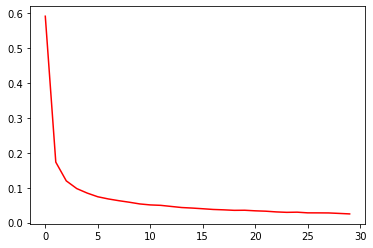

In [19]:
plt.plot(train_losses, color='red')

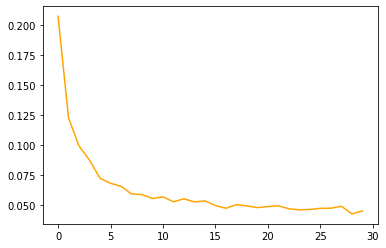

In [20]:
plt.plot(valid_losses, color='orange')

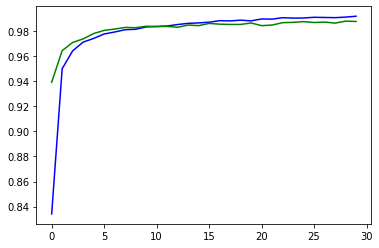

In [21]:
plt.plot(train_accuracies, color='blue')
plt.plot(valid_accuracies, color='green')

In [22]:
!pip install onnx onnxruntime --upgrade -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
beatrix-jupyterlab 3.1.6 requires google-cloud-bigquery-storage, which is not installed.
thinc 8.0.15 requires typing-extensions<4.0.0.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.1.1 which is incompatible.
tfx-bsl 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tfx-bsl 1.5.0 requires numpy<1.20,>=1.16, but you have numpy 1.21.6 which is incompatible.
tfx-bsl 1.5.0 requires pyarrow<6,>=1, but you have pyarrow 6.0.1 which is incompatible.
tfx-bsl 1.5.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.

In [23]:
import torch.onnx
import onnx
import onnxruntime

In [24]:
model = trainer.model

In [25]:
model.eval()

DigitsModel(
  (conv_stack): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=800, out_features=10, bias=True)
  )
)

In [26]:
# Input to the model
x = torch.randn(1, 1, 28, 28, requires_grad=True).to('cuda')
torch_out = model(x)

# Export the model
torch.onnx.export(model,                     # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "mnist.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})

In [27]:
onnx_model = onnx.load("mnist.onnx")
onnx.checker.check_model(onnx_model)